In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('./cifar-10-batches-py/data_batch_1', 'rb') as fo:
    d = pickle.load(fo, encoding='bytes')

print(d.keys())
data = d[b'data']
labels = d[b'labels']
print(data[0])

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
[ 59  43  50 ... 140  84  72]


In [3]:
# takes 1D array of pixel data and converts to MxNx3 RGB format
def reshape_img(pixeldata, m, n):
    return np.rot90(pixeldata.reshape((m, n, 3), order='F'), 3)

In [4]:
image_data = [reshape_img(img, 32, 32) for img in data]

In [5]:
label_strs = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def class_str(class_index):
    return label_strs[class_index]

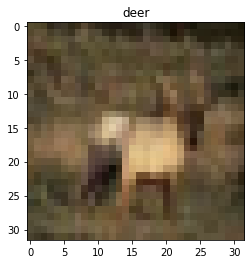

In [6]:
def display(image, index=-1):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if index >= 0:
        ax.set_title(class_str(labels[index]))
    plt.imshow(image)
    plt.show()

display(image_data[3], 3)

In [7]:
# Adding this AFTER I've made the CNN forward prop: we need
# to convert the classes given to us to one-hot-encoded vectors

def one_hot(label, num_labels):
    oh = np.zeros((num_labels))
    oh[label] = 1
    return oh

print(one_hot(5, 10))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
# Great, so now we have our image data in a good format. 

# Let's first try to make sense of how a CNN is structured

# We'll separate our data into training and testing groups later

### Convolutional Neural Network (CNN)
We have our input image, structured in a MxNx3 format (3 dimensions for R, G, and B values) 

The input image generally feeds directly into a convolutional layer. A convolutional layer is made up of multiple filters, each of the same size. Filters have a size, let's say fxf, where each value is a weight. We can think of the filters as a sort of sliding window that goes across and down its input. The filters also have a "stride," which is a measure of how quickly the filter "slides" across its input (ie. how many pixels does it jump)

Let's say we have F filters. S = stride. The output layer will be of size ((InpSize - F)/S + 1). 

In [9]:
# Okay then, we'll attempt a convolutional layer.

class ConvLayer:
    
    def __init__(self, num_filters, filter_size, inp_depth, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        
        # initialize filters randomly (divide by filter_size^2 to normalize)
        self.filters = np.random.randn(num_filters, filter_size, filter_size, inp_depth) / (filter_size**2)
        # self.filters = [[[0.1, 0.1], [0.1, 0.1]], [[0.2, 0.2], [0.2, 0.2]]]
    
    
    '''
    convolve takes a filter-sized patch of the image,
    a filter itself, and performs the convolve operation,
    returning a single sum
    '''
    def convolve(self, patch, f):
        s = 0
        height, width, depth = patch.shape
        for d in range(depth):
            for h in range(height):
                for w in range(width):
                    s += f[h][w]*patch[h][w][d]
        return s
    
    
    '''
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
        
    
    '''
    Forward propagation
    '''
    def forward_prop(self, image):
        self.image = image
        
        inp_height, inp_width, d = image.shape
        h_strides = int((inp_width - self.filter_size) / self.stride + 1)
        v_strides = int((inp_height - self.filter_size) / self.stride + 1)
        
        self.out_size = (h_strides, v_strides, self.num_filters)
        conv_out = np.zeros(self.out_size)
        
        for f, fltr in enumerate(self.filters):
            for i in range(0, v_strides):
                for j in range(0, h_strides):
                    conv_out[i, j, f] = np.sum(self.get_patch(image, i*self.stride, j*self.stride) * fltr)
                    # self.convolve(self.get_patch(image, i*self.stride, j*self.stride), fltr)
        return conv_out
    
    '''
    Backward propagation
    dL_dout - will be the gradients from the next ConvLayer
            (or the softmax layer if this is the last ConvLayer)
    learning_rate - parameter for updating weights 
    '''
    def backward_prop(self, dL_dout, learning_rate):
        dL_dW_params = np.zeros(self.filters.shape)
        
        h, w, d = self.image.shape
        h_strides, v_strides, nfilters = self.out_size   
        
        for i in range(h_strides):
            for j in range(v_strides):
                for f in range(nfilters):
                    for layer in range(d):
                        dL_dW_params[f] += self.get_patch(self.image, i*self.stride, j*self.stride) * dL_dout[i][j][f]

        self.filters -= learning_rate * dL_dW_params
        return dL_dW_params
        

In [10]:
# this is just a quick test of the forward prop math
D = ConvLayer(num_filters=2, filter_size=2, inp_depth=3)
test_img = np.array([
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ],
])
print(D.forward_prop(test_img))

[[[ 1.10757501 -1.0753546 ]
  [ 1.20539908 -1.40994247]]

 [[ 1.10757501 -1.0753546 ]
  [ 1.20539908 -1.40994247]]]


(29, 29, 10)


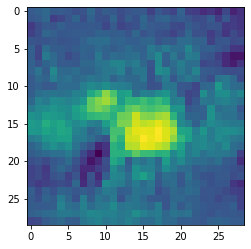

In [11]:
L = ConvLayer(num_filters=10, filter_size=4, inp_depth=3)
conv_out = L.forward_prop(image_data[3])
print(conv_out.shape)

# output of a single conv layer (one slice)
plt.imshow(conv_out[:,:,9])

In [12]:
# At the end of our sequence of ConvLayers, we'll need to flatten
# whatever output we get, in order to be fed into a softmax layer

# It doesn't *exactly* matter how we go about flattening this layer.
# The model will learn the patterns regardless of this layer's ordering
# (at least I think)

# EDIT: I'm just going to include this in the Softmax layer
# EDIT2: numpy has a built-in flatten function, I'll use that instead

def flatten(conv_out):
    height, width, depth = conv_out.shape
    out = np.zeros((height*width*depth,))
    i = 0
    for d in range(depth):
        for h in range(height):
            for w in range(width):
                out[i] = conv_out[h][w][d]
                i += 1
    
    return out

print(flatten(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
])))

print(np.array([
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
]).flatten())

[1. 4. 7. 2. 5. 8. 3. 6. 9.]
[1 2 3 4 5 6 7 8 9]


## Max pool layer
The max pool layer only takes one parameter, a filter size. The forward propagation will shrink the image by a factor of the filter size (but not alter the depth of the image), selecting the maximum values of each image patch over the image. 

The backward propagation will only backpropagate the gradients obtained from operating on those maximum values. The image patches have some max value, & *all* the values in that image patch are updated using that max value's computed gradient. 

In [13]:
# After the convolutional layer, we'll want to put our image thru
# a pooling layer. 

class MaxPoolLayer:
    
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    
    '''
    * used from ConvLayer *
    get_patch returns a filter-sized patch of the image,
    given an i,j coordinate (upper-left pixel)
    '''
    def get_patch(self, image, i, j):
        return image[i:(i+self.filter_size), j:(j+self.filter_size)]
    
    
    '''
    Max Pool forward propagation
    Output image is the same # of filters, but with width and height divided
    by the filter size - output arr[i, j] is the maximum value from the image
    patch at i,j (striding by filter_size)
    '''
    def forward_prop(self, image):
        self.image = image
        height, width, nfilters = image.shape
        
        self.out_size = (height // self.filter_size, width // self.filter_size, nfilters)
        out = np.zeros(self.out_size)
        
        for i in range(self.out_size[0]):
            for j in range(self.out_size[1]):
                out[i][j] = np.amax(self.get_patch(image, i*self.filter_size, j*self.filter_size), axis=(0,1))
                
        return out
    
    '''
    Max Pool backward propagation
    We only pass back the gradients computed using the maximum values
    from each of the image patches. Essentially we take the output-size gradient array,
    take each item from it, and "blow it back up" to be of the input size
    '''
    def backward_prop(self, dL_dout, learning_rate):
        dL_dMP = np.zeros(self.image.shape)
        height, width, nfilters = self.out_size
        
        for i in range(height):
            for j in range(width):
                image_patch = self.get_patch(self.image, i*self.filter_size, j*self.filter_size)
                max_val = np.amax(image_patch, axis=(0,1))
                h, w, f = image_patch.shape
                
                # iterate over inp image and 
                for ip in range(h):
                    for jp in range(w):
                        for fp in range(f):
                            if image_patch[ip][jp][fp] == max_val[fp]:
                                dL_dMP[i*self.filter_size + ip][j*self.filter_size + jp][fp] = dL_dout[i, j, fp]
                                
        return dL_dMP
        

In [15]:
# Let's test out forward prop

img = image_data[5]
M_P = MaxPoolLayer(2)
mp_out = M_P.forward_prop(conv_out)

print(conv_out.shape)
print(mp_out.shape)

(29, 29, 10)
(14, 14, 10)


In [16]:
# Now I guess we can start creating our softmax layer. 

# This layer takes a single-dimensional input, and gives an 
# output of size C, where C is # of classes we're training

class SoftmaxLayer:
    
    '''
    num_inputs - the total size of the output of the previous ConvLayer
    num_classes - number of classes we are training to predict
    '''
    def __init__(self, num_inputs, num_classes):
        
        # initialize weights & biases
        self.weights = np.random.randn(num_inputs, num_classes) / num_inputs
        self.biases = np.zeros(num_classes)
    
    
    '''
    Forward propagation, Softmax layer
    
    img - will be the "box" of z outputs from the last ConvLayer
    '''
    def forward_prop(self, img):
        
        # these will be used in backward propagation
        self.orig_img_shape = img.shape
        flattened = img.flatten()
        self.flattened = flattened
        # print('flattened fc layer: ', flattened)
        
        # this is our z values out of the FC layer
        out_val = np.dot(flattened, self.weights) + self.biases
        self.output = out_val
        
        # e^(z_i)
        exp_out = np.exp(self.output)
        
         # this is our y_hat predictions
        return exp_out / np.sum(exp_out, axis=0)
    
    
    '''
    Backward propagation, Softmax layer
    
    dL_dout - will be given from our model's main function - it is
    going to be the cross-entropy loss
    
    learning_rate - model's learning rate
    '''
    def backward_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue
            
            exp = np.exp(self.output)
            S_total = np.sum(exp)
            
            # case 2: i != l
            dy_dz = -exp[i] * exp / (S_total**2)
            
            # case 1: i == l (this is equiv. to y*(1-y))
            dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
            
            # dz_dw, dz_db, dz_dinput
            dz_dw = self.flattened
            dz_db = 1
            dz_dinput = self.weights
            
            # grad is dL_dy
            # dL/dz = dL/dy * dy/dz
            dL_dz = grad * dy_dz
            
            # loss wrt. weights, biases, input
            dL_dW = np.dot(dz_dw[np.newaxis].T, dL_dz[np.newaxis])
            dL_db = dL_dz * dz_db
            dL_dinput = np.dot(dz_dinput, dL_dz)
            
            # update weights and biases
            self.weights = self.weights - (learning_rate * dL_dW)
            self.biases = self.biases - (learning_rate * dL_db)
            
            return dL_dinput.reshape(self.orig_img_shape)
            

In [17]:
from math import prod
sm = SoftmaxLayer(prod(mp_out.shape), 10)
softmax_out = sm.forward_prop(mp_out)

print(softmax_out)


[0.04601474 0.1207467  0.05753969 0.35483431 0.005222   0.10768189
 0.0183812  0.10844462 0.1114495  0.06968535]


In [64]:
# Test run of one image forward prop thru whole model

img = image_data[5]
Conv1 = ConvLayer(num_filters=4, filter_size=4, inp_depth=3, stride=1)
MP1 = MaxPoolLayer(2)

# forward prop thru ConvLayers
c1_out = Conv1.forward_prop(img)
mp1_out = MP1.forward_prop(c1_out)

print(mp1_out.shape)

# softmax
softmax = SoftmaxLayer(prod(mp1_out.shape), 10)
softmax_out = softmax.forward_prop(mp1_out)

print(softmax_out)

(14, 14, 4)
[1.52908715e-04 5.85639091e-03 1.21478269e-01 2.48066778e-02
 1.31850018e-02 2.82051643e-03 8.06788190e-01 2.11445690e-02
 2.22753211e-03 1.53994445e-03]


### Calculating Cross-Entropy Loss
Cross-entropy loss is used for classification models w/ output between 0 and 1. I went through the math on my whiteboard here:

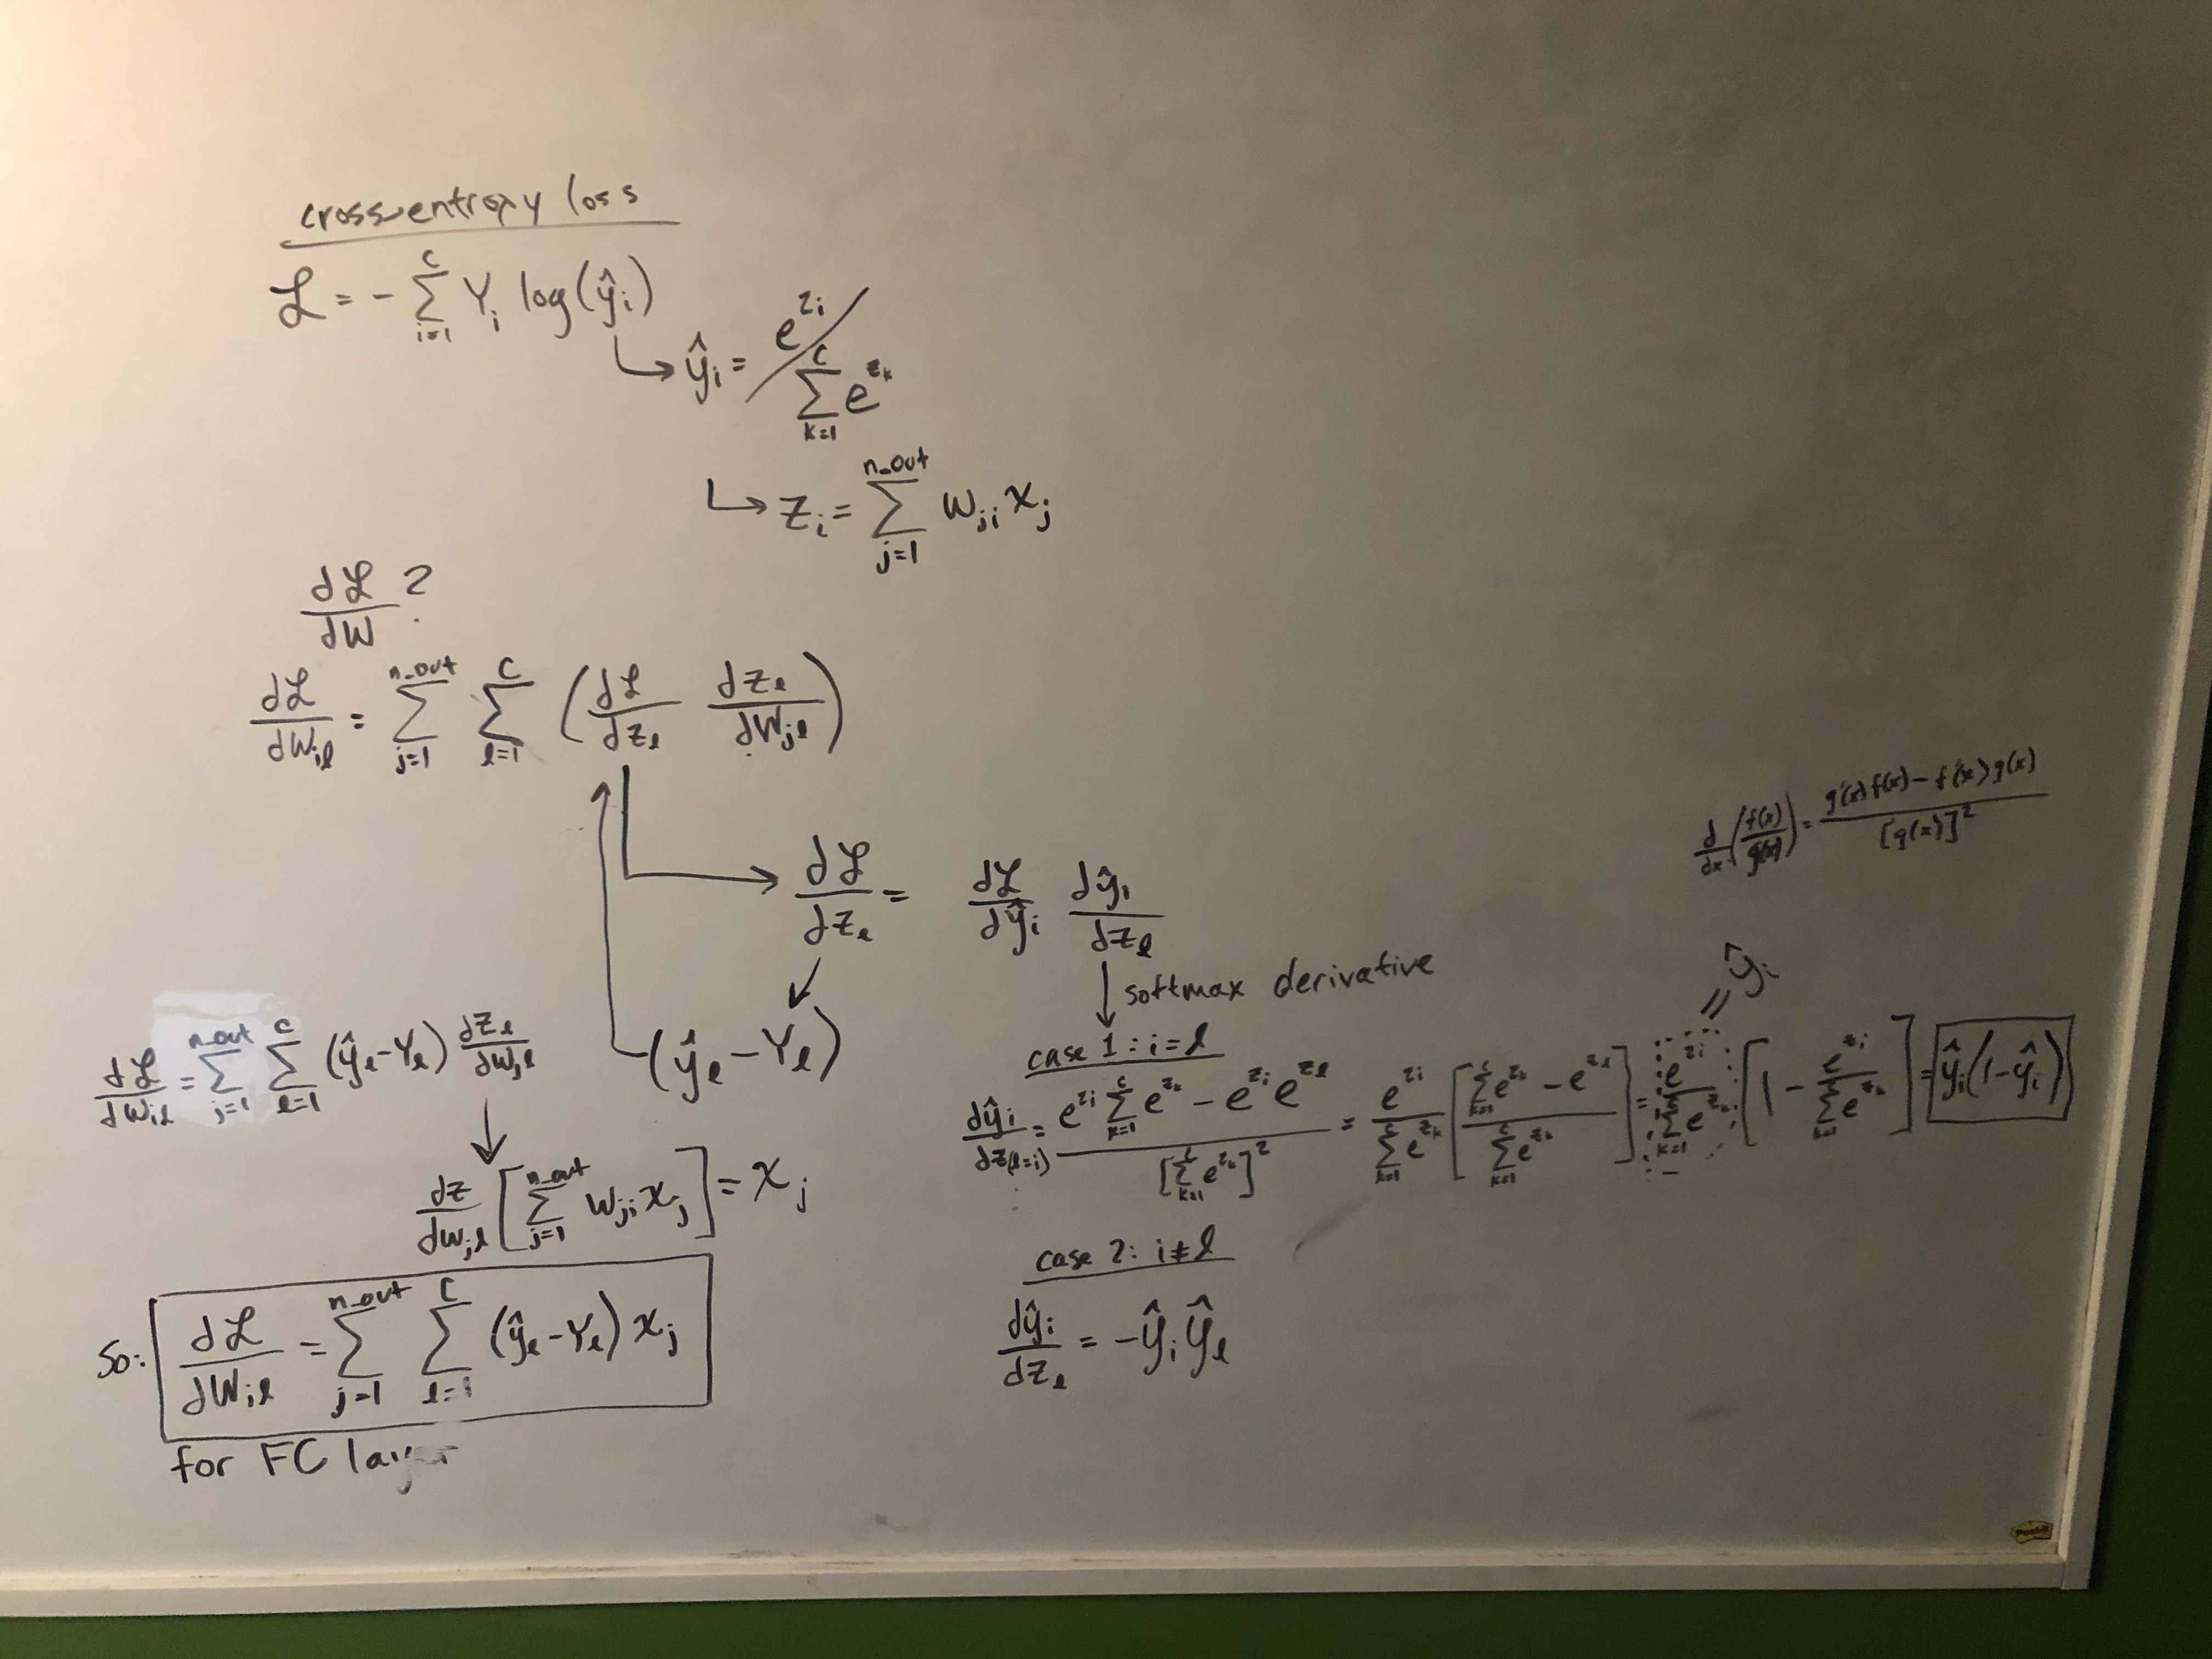

We use it to update weights & biases of both the fully-connected layer and the convolutional layers. 


In [65]:
# Test run of one image thru backpropagation

learning_rate = 0.01

l = 5
oh_l = one_hot(labels[l], 10)
cross_entropy_loss = -np.log(softmax_out[l])
accuracy = 0
if np.argmax(softmax_out) == l:
    accuracy = 1
    
gradient = np.zeros(10)
gradient[l] = -1/softmax_out[l]

backprop = softmax.backward_prop(gradient, learning_rate)
backprop = MP1.backward_prop(backprop, learning_rate)
backprop = Conv1.backward_prop(backprop, learning_rate)
print('conv backprop gradients shape: ', backprop.shape)

print(cross_entropy_loss, accuracy)

conv backprop gradients shape:  (4, 4, 4, 3)
5.870835281228023 0


### Now we have a 1-layer CNN
Let's try to train it

In [32]:
class CNNModel:
    def __init__(self, layers, num_classes, learning_rate=0.01):
        assert len(layers) >= 1
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward_prop(self, image, label):
        out_forward = self.layers[0].forward_prop(image)
        for layer in self.layers[1:]:
            out_forward = layer.forward_prop(out_forward)
        
        cross_entropy_loss = -np.log(out_forward[label])
        accuracy = 0
        if np.argmax(out_forward) == label:
            accuracy = 1
        
        return out_forward, cross_entropy_loss, accuracy
    
    def backward_prop(self, initial_gradient):
        back_gradient = self.layers[-1].backward_prop(initial_gradient, self.learning_rate)
        for layer in reversed(self.layers[:-1]):
            back_gradient = layer.backward_prop(back_gradient, self.learning_rate)
    
    def train_image(self, image, label):
        
        # Forward propagation
        out_fw, loss, acc = self.forward_prop(image, label)
        
        # calc initial gradient
        gradient = np.zeros(self.num_classes)
        gradient[label] = -1 / out_fw[label]
        
        # Backward propagation
        self.backward_prop(gradient)
        
        return loss, acc
    
    def classify(self, image, label):
        softmax_out, cel, accuracy = self.forward_prop(image, label)
        predicted = np.argmax(softmax_out)
        
        return predicted
    
    def assess_model(self, test_images, test_labels):
        predictions = np.zeros(len(test_images))
        num_correct = 0
        
        for i, (test_img, test_lbl) in enumerate(zip(test_images, test_labels)):
            predictions[i] = self.classify(test_img, test_lbl)
            
            if predictions[i] == test_lbl:
                num_correct += 1
        
        correct_percent = num_correct / len(test_images)
        
        return correct_percent, predictions
        

In [28]:
train_images = image_data[:9000]
test_images = image_data[9000:]

train_labels = labels[:9000]
test_labels = labels[9000:]

model_test = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=784, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.01
)

num_epochs = 1

for epoch in range(num_epochs):
    
    num_correct = 0
    loss = 0
    
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        l, a = model_test.train_image(image, label)
        
        loss += l
        num_correct += a
        
        if i % 100 == 0:
            print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
            loss = 0
            num_correct = 0

after 0 steps: num_correct: 0, avg loss: 1.5687896401118986


<ipython-input-16-5f539de7717f>:37: RuntimeWarning: overflow encountered in exp
  exp_out = np.exp(self.output)
<ipython-input-16-5f539de7717f>:40: RuntimeWarning: invalid value encountered in true_divide
  return exp_out / np.sum(exp_out, axis=0)
<ipython-input-27-508ff6af700f>:13: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = -np.log(out_forward[label])
<ipython-input-27-508ff6af700f>:32: RuntimeWarning: divide by zero encountered in double_scalars
  gradient[label] = -1 / out_fw[label]
<ipython-input-16-5f539de7717f>:56: RuntimeWarning: overflow encountered in exp
  exp = np.exp(self.output)
<ipython-input-16-5f539de7717f>:60: RuntimeWarning: invalid value encountered in true_divide
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-16-5f539de7717f>:63: RuntimeWarning: invalid value encountered in double_scalars
  dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
<ipython-input-16-5f539de7717f>:72: RuntimeWarning: invalid value encountered in multiply

after 100 steps: num_correct: 6, avg loss: nan
after 200 steps: num_correct: 8, avg loss: nan
after 300 steps: num_correct: 9, avg loss: nan
after 400 steps: num_correct: 12, avg loss: nan
after 500 steps: num_correct: 16, avg loss: nan
after 600 steps: num_correct: 7, avg loss: nan
after 700 steps: num_correct: 15, avg loss: nan
after 800 steps: num_correct: 12, avg loss: nan
after 900 steps: num_correct: 6, avg loss: nan
after 1000 steps: num_correct: 11, avg loss: nan
after 1100 steps: num_correct: 5, avg loss: nan
after 1200 steps: num_correct: 13, avg loss: nan
after 1300 steps: num_correct: 13, avg loss: nan
after 1400 steps: num_correct: 10, avg loss: nan


KeyboardInterrupt: 

In [ ]:
# Something is going wrong, I think during backpropagation. I just want to isolate
# one to two images and see what's going wrong. 

inp_img = image_data[7]
# label = 7 (horse) 
label = labels[7]
learning_rate=0.005

Conv = ConvLayer(num_filters=4, filter_size=4, inp_depth=3)
MaxPool = MaxPoolLayer(filter_size=2)
Softmax = SoftmaxLayer(num_inputs=784, num_classes=10)

conv_out = Conv.forward_prop(inp_img)
mp_out = MaxPool.forward_prop(conv_out)
sm_out = Softmax.forward_prop(mp_out)
print(sm_out)

cross_entropy_loss = -np.log(sm_out[label])
print('cross entropy loss: ', cross_entropy_loss)
accuracy = 1 if np.argmax(sm_out) == label else 0

gradient = np.zeros(10)
gradient[label] = -1/sm_out[label]

print(gradient)

grad_back = Softmax.backward_prop(gradient, learning_rate)
grad_back = MaxPool.backward_prop(grad_back, learning_rate)
grad_back = Conv.backward_prop(grad_back, learning_rate)

In [159]:
inp_img2 = image_data[8]
# label = 8 (ship)
label = labels[8]

conv_out = Conv.forward_prop(inp_img2)
print('conv out: ', conv_out)
mp_out = MaxPool.forward_prop(conv_out)
print('mp out: ', mp_out)
sm_out = Softmax.forward_prop(mp_out)
print('sm out: ', sm_out)

cel = -np.log(sm_out[label])
acc = 1 if np.argmax(sm_out) == label else 0

grad = np.zeros(10)
grad[label] = -1/sm_out[label]

grad_back = Softmax.backward_prop(grad, learning_rate)
grad_back = MaxPool.backward_prop(grad_back, learning_rate)
grad_back = Conv.backward_prop(grad_back, learning_rate)
# print(grad_back)

conv out:  [[[-353.91379478   42.55350862  -23.21699995 -225.23200375]
  [-354.39322902   42.76497328  -22.63969572 -225.59421769]
  [-354.36500209   44.04296923  -23.35545605 -225.56547197]
  ...
  [-351.2861697    45.09699051  -25.19435331 -222.73460167]
  [-351.7685225    44.35101863  -24.58147915 -224.25589161]
  [-355.53221181   44.25155398  -22.51832987 -227.63815806]]

 [[-354.43326373   43.34750646  -23.41532352 -224.85863172]
  [-354.96700015   43.04785265  -22.86869483 -225.45275131]
  [-356.10072554   43.57517065  -23.0751592  -226.38684996]
  ...
  [-348.93277833   42.19759941  -24.61361412 -222.10552078]
  [-350.55029071   43.01977012  -22.55332703 -223.64148908]
  [-354.69639655   43.54919183  -21.7684831  -227.11022429]]

 [[-353.6102218    43.10461234  -22.27533209 -225.28883409]
  [-354.09819768   42.97663203  -22.3242413  -225.4300101 ]
  [-355.21896014   43.0311486   -22.24342796 -226.4119752 ]
  ...
  [-348.72333874   41.83794872  -23.42422221 -221.44737352]
  [-352

In [154]:
# so clearly we're not even getting a good 2nd image result. 1st iteration goes fine but
# we blow up after going thru forward prop on the 2nd image.

###  I am getting super frustrated
I am going to switch to a different dataset, I'll just go with the "hello world" of CNNs,
the handwritten digits MNIST. It'll be one-dimensional, so I won't have to deal with 
RGB dimensions. I don't know if I jumped in too deep here or what, but I'm really
annoyed with this. 

# I might be an idiot
I just realized after tweaking the MNIST dataset that I never normalized the CIFAR inputs. I've been feeding the raw RGB values into this thing. 

I'll be happy/sad if this is the problem

In [30]:
normalized_images = np.array(image_data) / 255.0

train_images = normalized_images[:9000]
train_labels = labels[:9000]

test_images = normalized_images[9000:]
test_labels = labels[9000:]

print(normalized_images[0].shape)

(32, 32, 3)


In [22]:
model = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=784, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.01
)

num_epochs = 1

for epoch in range(num_epochs):
    
    num_correct = 0
    loss = 0
    
    for i, (image, label) in enumerate(zip(train_images, train_labels)):
        l, a = model.train_image(image, label)
        
        loss += l
        num_correct += a
        
        if i % 100 == 0:
            print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
            loss = 0
            num_correct = 0

after 0 steps: num_correct: 0, avg loss: 2.2948493653020483
after 100 steps: num_correct: 11, avg loss: 239.66363937907684
after 200 steps: num_correct: 11, avg loss: 246.21158047196866
after 300 steps: num_correct: 17, avg loss: 257.3601105884727
after 400 steps: num_correct: 18, avg loss: 255.0012265042839
after 500 steps: num_correct: 16, avg loss: 276.17453260848936
after 600 steps: num_correct: 13, avg loss: 267.85372338437236
after 700 steps: num_correct: 16, avg loss: 246.23525778941047
after 800 steps: num_correct: 14, avg loss: 344.99097707996793
after 900 steps: num_correct: 22, avg loss: 294.1595397498965


KeyboardInterrupt: 

# I can't believe myself

Well, it seems to be working now. 

I spent quite a while combing through every line of code in this thing, and it simply never occurred to me that I formatted my input incorrectly. 

In [39]:
def train_model(model, train_data, train_labels, epochs=1):
    for epoch in range(epochs):
        print('---------epoch {i}--------------'.format(i=epoch))
        num_correct = 0
        loss = 0

        for i, (image, label) in enumerate(zip(train_data, train_labels)):
            l, a = model.train_image(image, label)

            loss += l
            num_correct += a

            if i % 1000 == 0:
                print('after {steps} steps: num_correct: {acc}, avg loss: {loss}'.format(steps=i, acc=num_correct, loss=loss))
                loss = 0
                num_correct = 0

In [25]:
model_1 = CNNModel(
    layers=[
        ConvLayer(num_filters=8, filter_size=6, inp_depth=3),
        MaxPoolLayer(3),
        SoftmaxLayer(num_inputs=9*9*8, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

train_model(model_1, train_images, train_labels)

after 0 steps: num_correct: 0, avg loss: 2.306020180180441
after 1000 steps: num_correct: 169, avg loss: 2233.1558183701445
after 2000 steps: num_correct: 279, avg loss: 2047.9902063639747
after 3000 steps: num_correct: 298, avg loss: 2006.8897141013504
after 4000 steps: num_correct: 288, avg loss: 2043.7420278842455
after 5000 steps: num_correct: 310, avg loss: 2009.393427501144
after 6000 steps: num_correct: 308, avg loss: 2032.995326408338
after 7000 steps: num_correct: 335, avg loss: 2000.5611526192808
after 8000 steps: num_correct: 328, avg loss: 2004.6896577094951


In [26]:
model_2 = CNNModel(
    layers=[
        ConvLayer(num_filters=8, filter_size=5, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=14*14*8, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.007
)

train_model(model_2, train_images, train_labels)

after 0 steps: num_correct: 0, avg loss: 2.3068726334044234
after 1000 steps: num_correct: 167, avg loss: 2411.1946533516652
after 2000 steps: num_correct: 229, avg loss: 2552.039279042141
after 3000 steps: num_correct: 207, avg loss: 3197.9346282183114
after 4000 steps: num_correct: 183, avg loss: 3412.587515262943
after 5000 steps: num_correct: 202, avg loss: 4003.177161526272
after 6000 steps: num_correct: 196, avg loss: 5742.751205416907
after 7000 steps: num_correct: 192, avg loss: 6105.787001982142
after 8000 steps: num_correct: 182, avg loss: 7433.573454087859


In [37]:
model_3 = CNNModel(
    layers=[
        ConvLayer(num_filters=10, filter_size=8, inp_depth=3),
        MaxPoolLayer(3),
        SoftmaxLayer(num_inputs=8*8*10, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

train_model(model_3, train_images, train_labels, epochs=3)

---------epoch 1--------------
after 0 steps: num_correct: 0, avg loss: 2.3014675593717393
after 1000 steps: num_correct: 144, avg loss: 2259.2407670085545
after 2000 steps: num_correct: 261, avg loss: 2119.811792588877
after 3000 steps: num_correct: 274, avg loss: 2099.8737365761604
after 4000 steps: num_correct: 266, avg loss: 2151.309976238834
after 5000 steps: num_correct: 280, avg loss: 2085.376646797034
after 6000 steps: num_correct: 292, avg loss: 2100.841639007489
after 7000 steps: num_correct: 314, avg loss: 2060.5079476299475
after 8000 steps: num_correct: 309, avg loss: 2132.226367865522
---------epoch 1--------------
after 0 steps: num_correct: 0, avg loss: 3.1818980538594266
after 1000 steps: num_correct: 337, avg loss: 2028.6161971808958
after 2000 steps: num_correct: 362, avg loss: 2011.2518136795004
after 3000 steps: num_correct: 372, avg loss: 1962.3536913452422
after 4000 steps: num_correct: 363, avg loss: 2025.4095720766359
after 5000 steps: num_correct: 342, avg los

In [38]:
correct_percent, predictions = model_3.assess_model(test_images, test_labels)
print('percent correct: ', correct_percent*100, '%')

percent correct:  36.199999999999996 %


In [40]:
# 36% is pretty bad, let's try one last one, larger and train longer

model_4 = CNNModel(
    layers=[
        ConvLayer(num_filters=16, filter_size=6, inp_depth=3),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=13*13*16, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

train_model(model_4, train_images, train_labels, epochs=5)

---------epoch 0--------------
after 0 steps: num_correct: 0, avg loss: 2.3025835100699124
after 1000 steps: num_correct: 175, avg loss: 2277.818899710315
after 2000 steps: num_correct: 249, avg loss: 2222.706401687967
after 3000 steps: num_correct: 249, avg loss: 2254.252711194841
after 4000 steps: num_correct: 228, avg loss: 2339.620858890319
after 5000 steps: num_correct: 248, avg loss: 2304.6953885855137
after 6000 steps: num_correct: 243, avg loss: 2378.4536183969267
after 7000 steps: num_correct: 255, avg loss: 2402.6406093551254
after 8000 steps: num_correct: 243, avg loss: 2435.007771363314
---------epoch 1--------------
after 0 steps: num_correct: 0, avg loss: 4.194612546491404
after 1000 steps: num_correct: 308, avg loss: 2322.4801077470274
after 2000 steps: num_correct: 314, avg loss: 2382.1774196235106
after 3000 steps: num_correct: 301, avg loss: 2382.56557002636
after 4000 steps: num_correct: 292, avg loss: 2548.058585909682
after 5000 steps: num_correct: 288, avg loss: 2

<ipython-input-16-5f539de7717f>:60: RuntimeWarning: overflow encountered in multiply
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-16-5f539de7717f>:60: RuntimeWarning: overflow encountered in double_scalars
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-16-5f539de7717f>:60: RuntimeWarning: invalid value encountered in true_divide
  dy_dz = -exp[i] * exp / (S_total**2)
<ipython-input-16-5f539de7717f>:63: RuntimeWarning: overflow encountered in double_scalars
  dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)


after 5000 steps: num_correct: 273, avg loss: 17274.522480609186


KeyboardInterrupt: 

In [41]:
# I stopped after 3 epochs because loss started growing alarmingly again

correct_percent4, predictions4 = model_4.assess_model(test_images, test_labels)
print('percent correct: ', correct_percent4*100, '%')

percent correct:  30.3 %


I imagine we overfit this one. I'm sure we *could* get better results with more tweaking, but I'm unsure if we can make significant progress without having multiple ConvLayers.